In [1]:
# 코드 7-40 라이브러리 호출
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# 코드 7-41 데이터셋 가져오기
data = pd.read_csv("../chap07/data/SBUX.csv")
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [4]:
# 코드 7-42 날짜 칼럼을 인덱스로 사용
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)  # ‘date’ 칼럼을 인덱스로 사용

In [6]:
# 코드 7-43 데이터 형식 변경
data["Volume"] = data["Volume"].astype(
    float
)  # 데이터 형식을 변경할 때는 astype()을 사용>

In [7]:
# 코드 7-44 훈련과 레이블 분리
X = data.iloc[:, :-1]  # 마지막 칼럼을 제외한 모든 칼럼을 x로 사용
y = data.iloc[:, 5:6]  # 마지막 ‘Volume’을 레이블로 사용
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [8]:
# 코드 7-45 데이터 분포 조정
ms = MinMaxScaler()  # 데이터의 모든 값이 0~1 사이에 존재하도록 분산 조정
ss = StandardScaler()  # 데이터가 평균 0, 분산 1이 되도록 분산 조정

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]  # 훈련 데이터셋
X_test = X_ss[200:, :]  # 테스트 데이터셋

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [9]:
# 코드 7-46 데이터셋의 형태 및 크기 조정
X_train_tensors = Variable(
    torch.Tensor(X_train)
)  # Variable로 감싸진 텐서는 .backward( )가 호출될 때 자동으로 기울기가 계산
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(
    X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1])
)
X_test_tensors_f = torch.reshape(
    X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])
)

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [10]:
# 코드 7-47 LSTM 네트워크
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers  # LSTM 계층의 개수
        self.input_size = input_size  # 입력 크기로 훈련 데이터셋의 칼럼 개수를 의미
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length  # 시퀀스 길이

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )  # LSTM 계층
        self.fc_1 = nn.Linear(hidden_size, 128)  # 완전연결층
        self.fc = nn.Linear(128, num_classes)  # 출력층
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(
            torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        )  # 은닉 상태를 0으로 초기화
        c_0 = Variable(
            torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        )  # 셀 상태를 0으로 초기화
        output, (hn, cn) = self.lstm(
            x, (h_0, c_0)
        )  # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(
            -1, self.hidden_size
        )  # 완전연결층 적용을 위해 데이터의 형태 조정(1차원으로 조정)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [11]:
# 코드 7-48 변수 값 설정
num_epochs = 1000  # 1000번의 에포크
learning_rate = 0.0001  # 학습률을 0.0001로 지정

input_size = 5  # 입력 데이터셋의 칼럼(feature) 개수
hidden_size = 2  # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1  # 클래스 개수
model = LSTM(
    num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]
)  # 앞에서 정의한 값들을 이용하여 LSTM 모델 학습

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# 코드 7-49 모델 학습
for epoch in range(num_epochs):  # 1000번 반복
    outputs = model.forward(X_train_tensors_f)  # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(
        outputs, y_train_tensors
    )  # 손실 함수를 이용한 오차 계산(모델 학습 결과(outputs)와 레이블(y_train_tensors)의 차이 계산)
    loss.backward()  # 기울기 계산

    optimizer.step()  # 오차 업데이트
    if epoch % 100 == 0:  # 1000을 100으로 나누어 나머지가 0이면 출력
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.32160
Epoch: 100, loss: 0.09780
Epoch: 200, loss: 0.03949
Epoch: 300, loss: 0.03074
Epoch: 400, loss: 0.02900
Epoch: 500, loss: 0.02781
Epoch: 600, loss: 0.02681
Epoch: 700, loss: 0.02598
Epoch: 800, loss: 0.02527
Epoch: 900, loss: 0.02462


In [13]:
# 코드 7-50 모델 예측 결과를 출력하기 위한 데이터 크기 재구성
df_x_ss = ss.transform(data.iloc[:, :-1])  # 데이터 정규화(분포 조정)
df_y_ms = ms.transform(data.iloc[:, -1:])  # 데이터 정규화

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

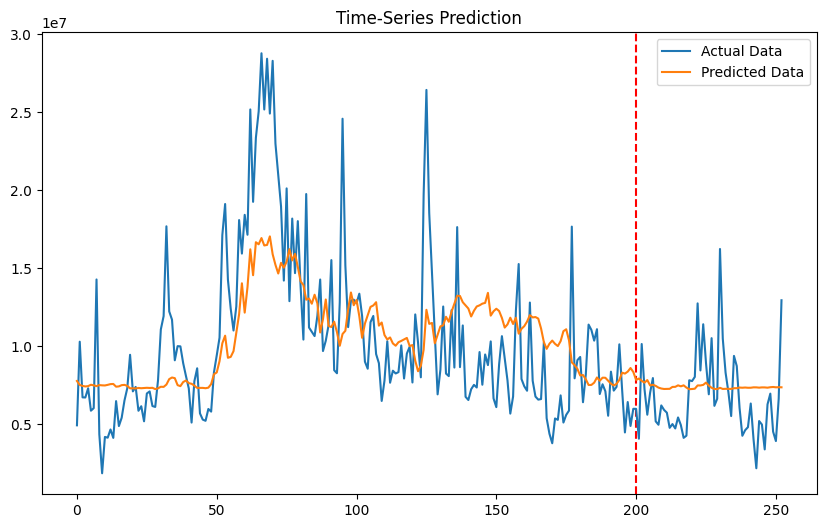

In [14]:
# 코드 7-51 모델 예측 결과 출력
train_predict = model(df_x_ss)  # 훈련 데이터셋을 모델에 적용하여 모델 학습
predicted = train_predict.data.numpy()  # 모델 학습 결과를 넘파이로 변경
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(
    predicted
)  # 모델 학습을 위해 전처리(정규화)했던 것을 해제(그래프의 본래 값을 출력하기 위한 목적)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))  # 그래프로 표시(plotting)
plt.axvline(x=200, c="r", linestyle="--")

plt.plot(label_y, label="Actual Data")
plt.plot(predicted, label="Predicted Data")
plt.title("Time-Series Prediction")
plt.legend()
plt.show()